# 2. NY Person Car Trip Predictor 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math
import time
warnings.filterwarnings('ignore')

In [3]:
path = "C:\SMU Term 3\Applied Machine Learning\Project\csv"

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))

In [24]:
# get csv files from teams first
acs_age = pd.read_csv("".join([path,'/ACS_2017_age.csv']))
acs_race = pd.read_csv("".join([path,'/ACS_2017_race.csv']))

In [25]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## 2.1 Data Preperation

## 2.1.1. Household

In [6]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 2.1.2. Trips 

In [7]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [8]:
ny_trip_person = ny_trip[['HOUSEID','PERSONID']].drop_duplicates()

In [9]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_cartrip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [10]:
print(str(sum(ny_cartrip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_cartrip = ny_cartrip[ny_cartrip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.135544289536685 %


In [11]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_cartrip = ny_cartrip[ny_cartrip['TRPMILES']>0]

# of trips with dist <=0, 200  out of 113616


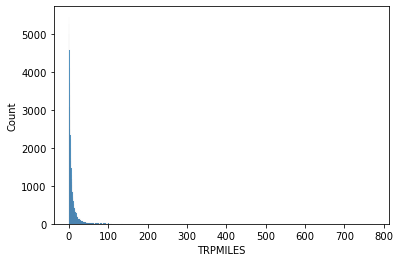

In [12]:
#Remove outlier trip miles
sns.histplot(ny_cartrip['TRPMILES'])
ny_cartrip = ny_cartrip[ny_cartrip['TRPMILES']<100]

In [13]:
# Summarise to Person trip counts 
ny_trip_count = ny_cartrip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})
ny_trip_count

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,5
3,30000380,1,3
4,30000380,2,8
...,...,...,...
22054,40793808,1,2
22055,40793808,2,9
22056,40793808,3,5
22057,40793974,1,7


In [14]:
# combine with all people from trips list to include 0 trip
ny_trip_count = ny_trip_person.merge(ny_trip_count, how = 'outer', left_on = ['HOUSEID','PERSONID'], right_on = ['HOUSEID','PERSONID'])

### 2.1.3. Person

In [15]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [16]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY','DISTTOWK17','DISTTOSC17','OUTOFTWN']]

In [17]:
# Remove those out of town
nyorker = nyorker[nyorker['OUTOFTWN']==2]
nyorker.drop(['OUTOFTWN'],axis =1, inplace = True)

### 2.1.4. Combined Dataframe

In [18]:
# merging of Person, Household and Trips to Person
df= nyorker.merge(ny_trip_count, how = 'left', left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])
df = df.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')
df.shape

(31051, 28)

## 2.2. Reason For Model

### 2.2.1. Age

In [19]:
# Binnig of age to allow for comparison with ACS (population statistics)
nyorker['AGE_bins']= 'NA'
nyorker.loc[nyorker['R_AGE'].between(0,4,inclusive = True), 'AGE_bins'] = "Under 5 years"
nyorker.loc[nyorker['R_AGE'].between(5,9,inclusive = True), 'AGE_bins'] = "5 to 9 years"
nyorker.loc[nyorker['R_AGE'].between(10,14,inclusive = True), 'AGE_bins'] = "10 to 14 years"
nyorker.loc[nyorker['R_AGE'].between(15,19,inclusive = True), 'AGE_bins'] = "15 to 19 years"
nyorker.loc[nyorker['R_AGE'].between(20,24,inclusive = True), 'AGE_bins'] = "20 to 24 years"
nyorker.loc[nyorker['R_AGE'].between(25,29,inclusive = True), 'AGE_bins'] = "25 to 29 years"
nyorker.loc[nyorker['R_AGE'].between(30,34,inclusive = True), 'AGE_bins'] = "30 to 34 years"
nyorker.loc[nyorker['R_AGE'].between(35,39,inclusive = True), 'AGE_bins'] = "35 to 39 years"
nyorker.loc[nyorker['R_AGE'].between(40,44,inclusive = True), 'AGE_bins'] = "40 to 44 years"
nyorker.loc[nyorker['R_AGE'].between(45,49,inclusive = True), 'AGE_bins'] = "45 to 49 years"
nyorker.loc[nyorker['R_AGE'].between(50,54,inclusive = True), 'AGE_bins'] = "50 to 54 years"
nyorker.loc[nyorker['R_AGE'].between(55,59,inclusive = True), 'AGE_bins'] = "55 to 59 years"
nyorker.loc[nyorker['R_AGE'].between(60,64,inclusive = True), 'AGE_bins'] = "60 to 64 years"
nyorker.loc[nyorker['R_AGE'].between(65,69,inclusive = True), 'AGE_bins'] = "65 to 69 years"
nyorker.loc[nyorker['R_AGE'].between(70,74,inclusive = True), 'AGE_bins'] = "70 to 74 years"
nyorker.loc[nyorker['R_AGE'].between(75,79,inclusive = True), 'AGE_bins'] = "75 to 79 years"
nyorker.loc[nyorker['R_AGE'].between(80,84,inclusive = True), 'AGE_bins'] = "80 to 84 years"
nyorker.loc[nyorker['R_AGE']>=85, 'AGE_bins'] = "85 years and over"

In [20]:
survey_age = nyorker['PERSONID'][nyorker['AGE_bins']!='NA'].groupby(nyorker['AGE_bins']).count().reset_index().rename(columns ={'PERSONID':'NHTS_count'})
total = sum(survey_age['NHTS_count'])
survey_age['pct'] = survey_age['NHTS_count']/total*100
survey_age['Type'] = "NHTS"
survey_age.drop('NHTS_count',axis = 1,inplace = True)

Text(0.5, 1.0, 'Comparison of Age Bin distribution between NHTS and ACS')

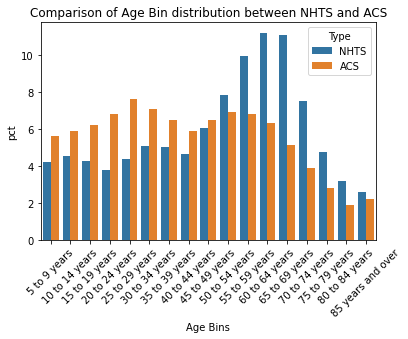

In [26]:
acs_age['Type']= "ACS"
acs_age = acs_age[acs_age['AGE_bins']!= 'Under 5 years']
age_plot= pd.concat([survey_age,acs_age])

age_plot =age_plot.rename(columns={'AGE_bins':'Age Bins'})
#acs_age

order = [ "5 to 9 years", "10 to 14 years","15 to 19 years","20 to 24 years","25 to 29 years",
         "30 to 34 years", "35 to 39 years", "40 to 44 years","45 to 49 years","50 to 54 years",
         "55 to 59 years","60 to 64 years","65 to 69 years","70 to 74 years", "75 to 79 years",
         "80 to 84 years","85 years and over"]
sns.barplot(data = age_plot, x = 'Age Bins', y = 'pct', hue = 'Type',order =order)
plt.xticks(rotation=45)
plt.title('Comparison of Age Bin distribution between NHTS and ACS')

Significant differnet between population distribution vs survey distribution for the various age groups. Cannot simply multiply survey with a factor to get population statistics

### 2.2.2 Race

In [27]:
#Classifing race similiar to ACS data based on data dictionary
nyorker['Race']= "NA"
nyorker.loc[nyorker['R_RACE']==1,'Race']= "White"
nyorker.loc[nyorker['R_RACE']==2,'Race']= "Black or African American"
nyorker.loc[nyorker['R_RACE']==3,'Race']= "Asian"
nyorker.loc[nyorker['R_RACE']==4,'Race']= "American Indian"
nyorker.loc[nyorker['R_RACE']==5,'Race']= "Native Hawaiian"
nyorker.loc[nyorker['R_RACE']==6,'Race']= "Multiple Race"
nyorker.loc[nyorker['R_RACE']==97,'Race'] = "Other"

In [28]:
survey_race = nyorker['PERSONID'][nyorker['Race']!='NA'].groupby(nyorker['Race']).count().reset_index().rename(columns ={'PERSONID':'NHTS_count'})
total = sum(survey_race['NHTS_count'])
survey_race['pct'] = survey_race['NHTS_count']/total*100
survey_race['Source'] = "NHTS"
survey_race.drop('NHTS_count',axis = 1,inplace = True)
acs_race.drop('count',axis = 1, inplace = True)

Text(0.5, 1.0, 'Comparison of Race distribution between NHTS and ACS')

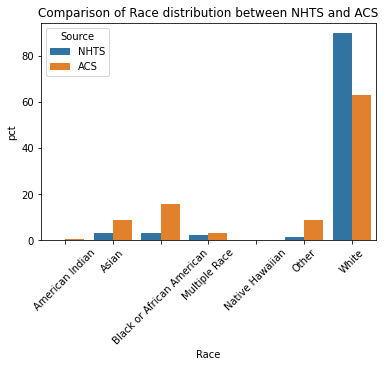

In [29]:
race_plot= pd.concat([survey_race,acs_race])
#acs_age
sns.barplot(data = race_plot, x = 'Race', y = 'pct', hue = 'Source')
plt.xticks(rotation=45)
plt.title('Comparison of Race distribution between NHTS and ACS')

Similiarly over distribution of white race in survey which could under-represent other races

### As such to create a model where able to put input data with balanced distribution of data and from there aggregate up to get population statistics

## 2.3. EDA

### 2.3.1. Train, Test, Split

In [30]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_col = [c for c in df if c not in ["n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

### 2.3.2 Feature Engineering

#### n_trips

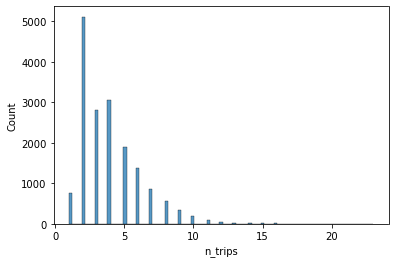

In [31]:
# Replace NA trip counts with 0
sns.histplot(y_train)
y_train[y_train.isna()] = 0
x_train = x_train[y_train<10]
y_train = y_train[y_train<10]

y_test[y_test.isna()] = 0
x_test = x_test[y_test<10]
y_test = y_test[y_test<10]

In [32]:
y_train.value_counts()

print(pd.concat([y_train.value_counts(),
                 y_train.value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))


     counts  percentage
0.0    7650   31.301146
2.0    5112   20.916530
4.0    3054   12.495908
3.0    2813   11.509820
5.0    1890    7.733224
6.0    1381    5.650573
7.0     868    3.551555
1.0     768    3.142390
8.0     568    2.324059
9.0     336    1.374795


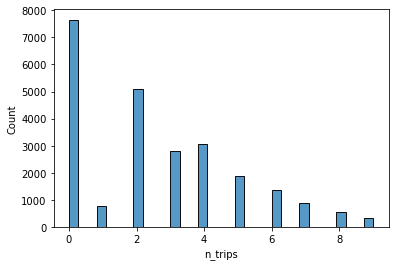

In [33]:
sns.histplot(y_train)

In [34]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24440 entries, 19802 to 10750
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HOUSEID     24440 non-null  int64  
 1   PERSONID    24440 non-null  int64  
 2   R_AGE       24440 non-null  int64  
 3   EDUC        24440 non-null  int64  
 4   R_RACE      24440 non-null  int64  
 5   R_SEX       24440 non-null  int64  
 6   WRK_HOME    24440 non-null  int64  
 7   WKFTPT      24440 non-null  int64  
 8   OCCAT       24440 non-null  int64  
 9   DRIVER      24440 non-null  int64  
 10  TRAVDAY     24440 non-null  int64  
 11  DISTTOWK17  24440 non-null  float64
 12  DISTTOSC17  24440 non-null  float64
 13  HH_CBSA     24440 non-null  object 
 14  HOMEOWN     24440 non-null  int64  
 15  HHSIZE      24440 non-null  int64  
 16  HHVEHCNT    24440 non-null  int64  
 17  HHFAMINC    24440 non-null  int64  
 18  NUMADLT     24440 non-null  int64  
 19  YOUNGCHILD  24440 non

#### Age (R_AGE)

61 count of people with no age.  0.0002762702755890612 %.


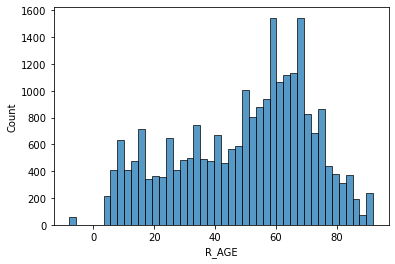

In [35]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [36]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = "more_than_75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = "more_than_75"


              counts  percentage
56_to_65        5266   21.546645
66_to_75        4210   17.225859
46_to_55        3619   14.807692
5_to_15         2392    9.787234
36_to_45        2384    9.754501
26_to_35        2375    9.717676
more_than_75    2246    9.189853
16_to_25        1948    7.970540


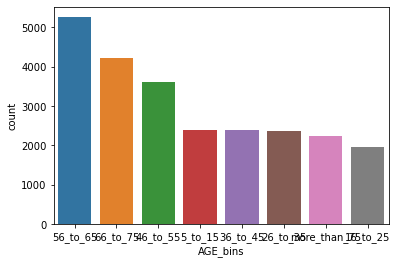

In [37]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    6082   24.885434
 5    5347   21.878069
 2    4823   19.734043
 4    4652   19.034370
-1    1920    7.855974
 1    1599    6.542553
-7      11    0.045008
-8       6    0.024550


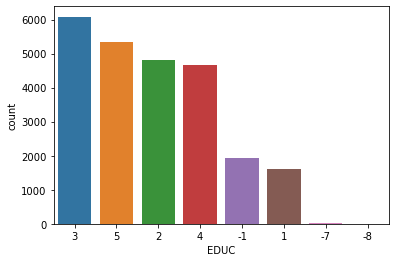

In [38]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    21833   89.333061
 3      793    3.244681
 2      793    3.244681
 6      522    2.135843
 97     295    1.207038
-7      119    0.486907
 4       58    0.237316
 5       15    0.061375
-8       12    0.049100


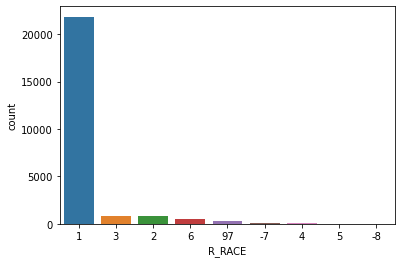

In [39]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   12725   52.066285
 1   11691   47.835516
-7      21    0.085925
-8       3    0.012275


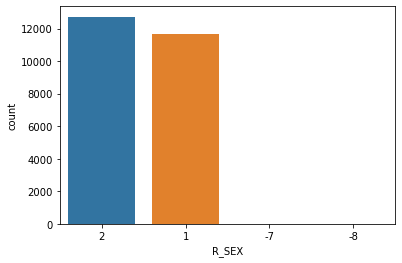

In [40]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12176   49.819967
 2   10537   43.113748
 1    1274    5.212766
-9     452    1.849427
-7       1    0.004092


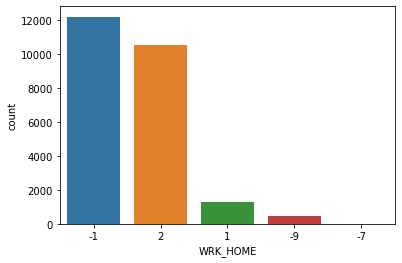

In [41]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   12628   51.669394
 1    9179   37.557283
 2    2627   10.748773
-7       4    0.016367
-8       2    0.008183


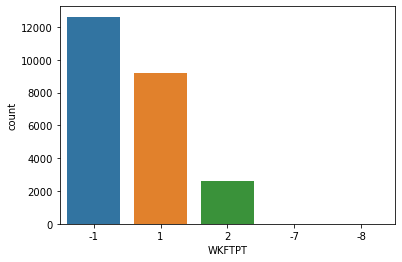

In [42]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12176   49.819967
 4     6451   26.395254
 1     2523   10.323241
 3     1441    5.896072
 2     1373    5.617840
-9      452    1.849427
 97      17    0.069558
-8        5    0.020458
-7        2    0.008183


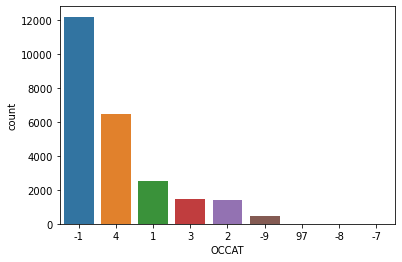

In [43]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   20593   84.259411
-1    2148    8.788871
 2    1699    6.951718


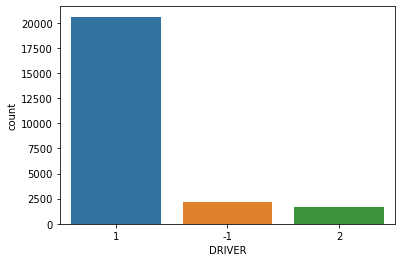

In [44]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
#sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Distance to Work

In [45]:
#To Bin Non zeros
#sns.histplot(x_train['DISTTOWK17'])
pd.qcut(x_train['DISTTOWK17'][x_train['DISTTOWK17']>0],5)

4039                  (22.05, 2919.7]
27793                  (12.27, 22.05]
26243                    (6.9, 12.27]
1759     (0.009000000000000001, 3.13]
21860    (0.009000000000000001, 3.13]
                     ...             
30429                 (22.05, 2919.7]
18832                 (22.05, 2919.7]
13421                 (22.05, 2919.7]
10940                    (6.9, 12.27]
25839                  (12.27, 22.05]
Name: DISTTOWK17, Length: 10471, dtype: category
Categories (5, interval[float64]): [(0.009000000000000001, 3.13] < (3.13, 6.9] < (6.9, 12.27] < (12.27, 22.05] < (22.05, 2919.7]]

                   counts  percentage
NA                  13969   57.156301
DISTTOWK_3_to_7      2227    9.112111
DISTTOWK_12_to_22    2163    8.850245
DISTTOWK_above_22    2103    8.604746
DISTTOWK_0_to_3      2011    8.228314
DISTTOWK_7_to_12     1967    8.048282


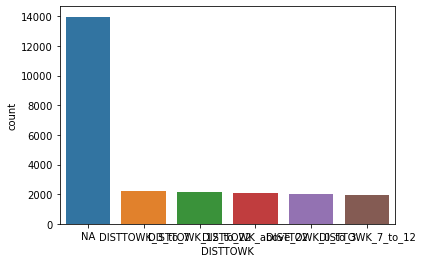

In [46]:
x_train['DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17']==0, 'DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17']==-9, 'DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17'].between(.009000000000000000,3,inclusive = True),'DISTTOWK'] = 'DISTTOWK_0_to_3'
x_train.loc[x_train['DISTTOWK17'].between(3,7, inclusive = True),'DISTTOWK'] = 'DISTTOWK_3_to_7'
x_train.loc[x_train['DISTTOWK17'].between(7,12, inclusive = True),'DISTTOWK'] = 'DISTTOWK_7_to_12'
x_train.loc[x_train['DISTTOWK17'].between(12,22, inclusive = True),'DISTTOWK'] = 'DISTTOWK_12_to_22'
x_train.loc[x_train['DISTTOWK17']>22,'DISTTOWK'] = 'DISTTOWK_above_22'
cat_col_prop(x_train,'DISTTOWK')
x_train.drop(['DISTTOWK17'],axis=1, inplace = True)

x_test['DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17']==0, 'DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17']==-9, 'DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17'].between(.009000000000000000,3,inclusive = True),'DISTTOWK'] = 'DISTTOWK_0_to_3'
x_test.loc[x_test['DISTTOWK17'].between(3,7, inclusive = True),'DISTTOWK'] = 'DISTTOWK_3_to_7'
x_test.loc[x_test['DISTTOWK17'].between(7,12, inclusive = True),'DISTTOWK'] = 'DISTTOWK_7_to_12'
x_test.loc[x_test['DISTTOWK17'].between(12,22, inclusive = True),'DISTTOWK'] = 'DISTTOWK_12_to_22'
x_test.loc[x_test['DISTTOWK17']>22,'DISTTOWK'] = 'DISTTOWK_above_22'
x_test.drop(['DISTTOWK17'],axis=1, inplace = True)

#### Distance to School

In [47]:
pd.qcut(x_train['DISTTOSC17'][x_train['DISTTOSC17']>0],2)

20475                 (2.82, 2784.08]
1070     (0.009000000000000001, 2.82]
6430                  (2.82, 2784.08]
18170    (0.009000000000000001, 2.82]
18134                 (2.82, 2784.08]
                     ...             
22318                 (2.82, 2784.08]
22682                 (2.82, 2784.08]
2451     (0.009000000000000001, 2.82]
25574                 (2.82, 2784.08]
23667                 (2.82, 2784.08]
Name: DISTTOSC17, Length: 2707, dtype: category
Categories (2, interval[float64]): [(0.009000000000000001, 2.82] < (2.82, 2784.08]]

                  counts  percentage
NA                 21733   88.923895
DISTTOSC_under_3    1410    5.769231
DISTTOSC_above_3    1297    5.306874


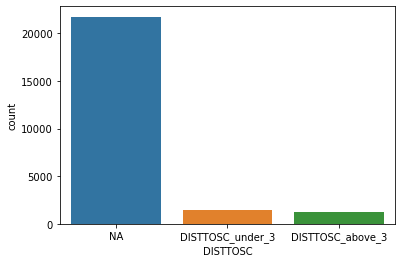

In [48]:
x_train['DISTTOSC'] = 'NA'
x_train.loc[x_train['DISTTOSC17']<=0, 'DISTTOSC'] = 'NA'
x_train.loc[x_train['DISTTOSC17'].between(.008,3,inclusive = True),'DISTTOSC'] = 'DISTTOSC_under_3'
x_train.loc[x_train['DISTTOSC17']>3,'DISTTOSC'] = 'DISTTOSC_above_3'
cat_col_prop(x_train,'DISTTOSC')
x_train.drop(['DISTTOSC17'],axis=1, inplace = True)


x_test['DISTTOSC'] = 'NA'
x_test.loc[x_test['DISTTOSC17']<=0, 'DISTTOSC'] = 'NA'
x_test.loc[x_test['DISTTOSC17'].between(.008,3,inclusive = True),'DISTTOSC'] = 'DISTTOSC_under_3'
x_test.loc[x_test['DISTTOSC17']>3,'DISTTOSC'] = 'DISTTOSC_above_3'
x_test.drop(['DISTTOSC17'],axis=1, inplace = True)

#### Travel Day (TRAVDAY)

   counts  percentage
1    3602   14.738134
2    3575   14.627660
5    3538   14.476268
7    3488   14.271686
6    3482   14.247136
3    3417   13.981178
4    3338   13.657938


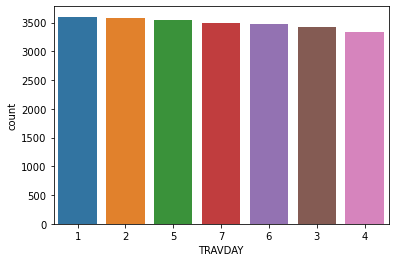

In [49]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   14487   59.275777
35620    7368   30.147300
40380    1398    5.720131
15380    1187    4.856792


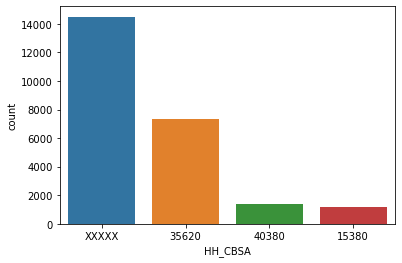

In [50]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    20559   84.120295
 2     3696   15.122750
 97     183    0.748773
-7        2    0.008183


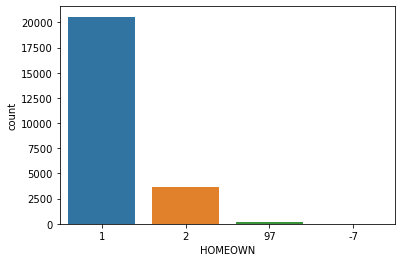

In [51]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    10850   44.394435
1     6442   26.358429
3     4462   18.256956
4     1715    7.017185
5      621    2.540917
6      224    0.916530
7       81    0.331424
8       23    0.094108
11      10    0.040917
9        9    0.036825
12       3    0.012275
________
new HHVEHCNT
    counts  percentage
2    10850   44.394435
1     6442   26.358429
3     4462   18.256956
>3    2686   10.990180


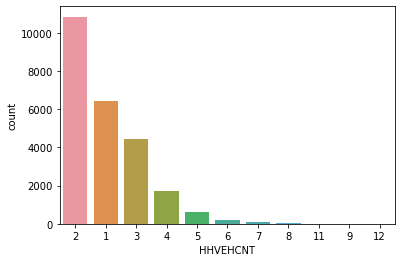

In [52]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4358   17.831424
 7     3688   15.090016
 8     2979   12.189034
 5     2607   10.666939
 4     1925    7.876432
 9     1779    7.279051
 11    1721    7.041735
 10    1710    6.996727
 3     1567    6.411620
-7      732    2.995090
 2      721    2.950082
 1      550    2.250409
-8      101    0.413257
-9        2    0.008183


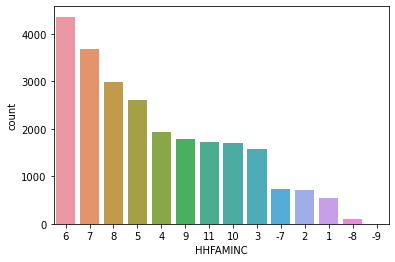

In [53]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    15533   63.555646
1     4108   16.808511
3     3359   13.743863
4     1113    4.554010
5      265    1.084288
6       38    0.155483
7       12    0.049100
10       7    0.028642
8        5    0.020458


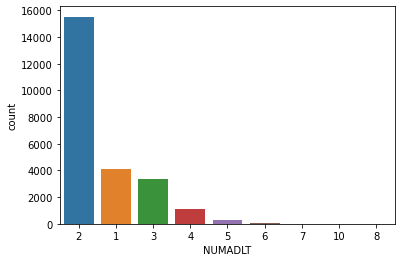

In [54]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   16904   69.165303
0.500000    2696   11.031097
0.666667    1860    7.610475
0.400000     868    3.551555
0.750000     645    2.639116
0.333333     468    1.914894
0.600000     363    1.485270
0.800000     206    0.842881
0.250000      90    0.368249
0.285714      69    0.282324
0.714286      47    0.192308
0.833333      43    0.175941
0.428571      40    0.163666
0.571429      34    0.139116
0.200000      18    0.073650
0.375000      18    0.073650
0.222222      17    0.069558
0.444444      14    0.057283
0.625000      13    0.053191
0.166667       7    0.028642
0.700000       6    0.024550
0.857143       6    0.024550
0.142857       5    0.020458
0.363636       3    0.012275

After
               counts  percentage
1               16904   69.165303
more_than_0.5    5919   24.218494
less_than_0.5    1617    6.616203


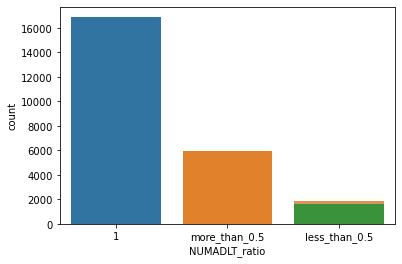

In [55]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   22248   91.031097
1    1631    6.673486
2     511    2.090835
3      45    0.184124
5       3    0.012275
4       2    0.008183


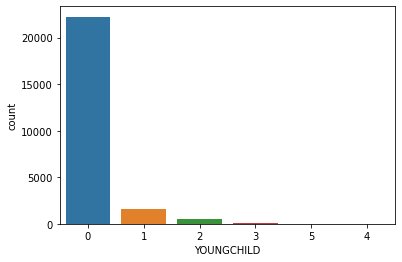

In [56]:
cat_col_prop(x_train,'YOUNGCHILD')

               counts  percentage
0               22248   91.031097
less_than_0.5    1878    7.684124
more_than_0.5     314    1.284779


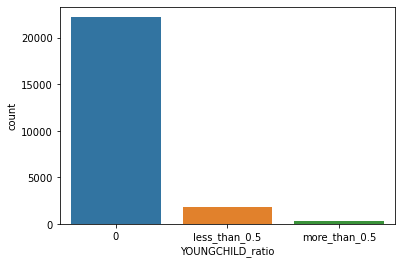

In [57]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'

#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8387   34.316694
1    7463   30.536007
0    6402   26.194763
3    1627    6.657119
4     501    2.049918
5      51    0.208674
7       5    0.020458
6       4    0.016367


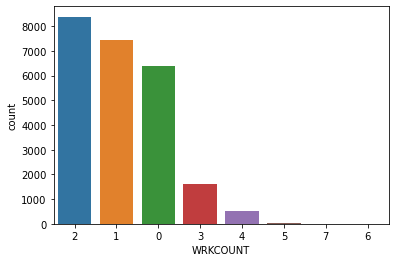

In [58]:
cat_col_prop(x_train,'WRKCOUNT')

               counts  percentage
more_than_0.5    8056   32.962357
0                6402   26.194763
1                6150   25.163666
less_than_0.5    3832   15.679214


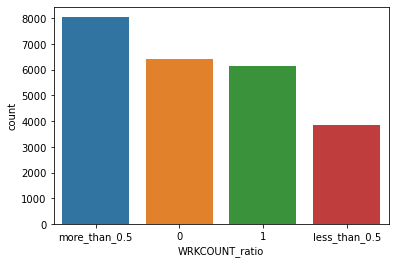

In [59]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

#### Household Size (HHSIZE)

Before
    counts  percentage
2    10419   42.630933
3     4188   17.135843
4     3810   15.589198
1     3568   14.599018
5     1604    6.563011
6      489    2.000818
7      207    0.846972
8       82    0.335516
9       44    0.180033
10      26    0.106383
11       3    0.012275

After
         counts  percentage
2         10419   42.630933
above_3    6265   25.634206
3          4188   17.135843
1          3568   14.599018


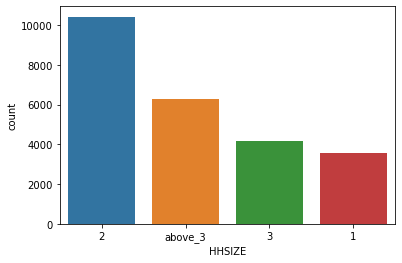

In [60]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = "above_3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = " above_3"

#### Metropolitan Statistical Area (MSACAT)

   counts  percentage
3   10538   43.117840
1    7368   30.147300
4    3949   16.157938
2    2585   10.576923


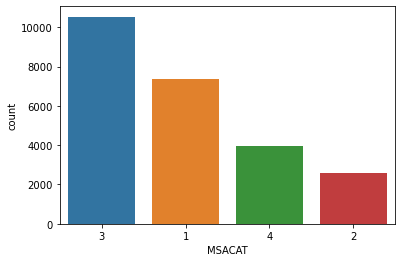

In [61]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7368   30.147300
1    6149   25.159574
6    3949   16.157938
3    3287   13.449264
4    2585   10.576923
2    1102    4.509002


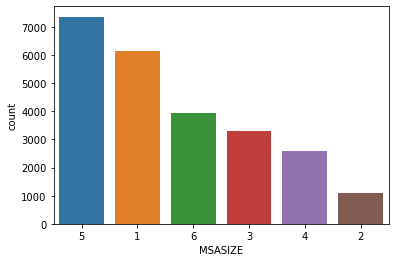

In [62]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   13708   56.088380
4    8342   34.132570
2    2385    9.758592
3       5    0.020458

After
       counts  percentage
urban   16093   65.846972
rural    8347   34.153028


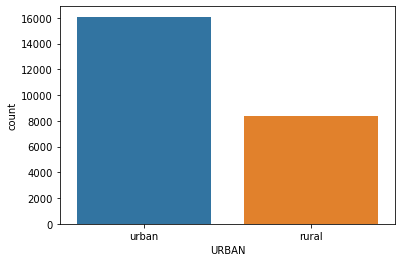

In [63]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   10732   43.911620
5    4727   19.341244
1    3738   15.294599
3    2739   11.207038
2    2504   10.245499


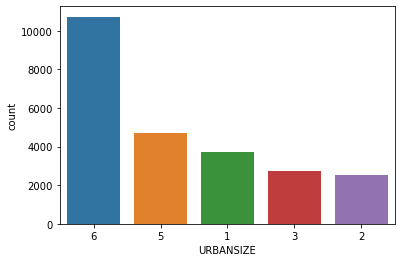

In [64]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   16093   65.846972
2    8347   34.153028


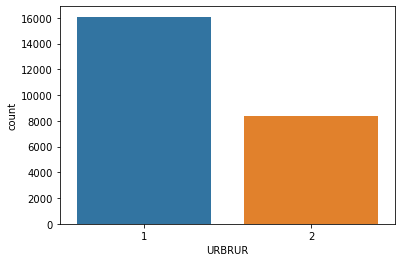

In [65]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    6785   27.761866
2     5514   22.561375
6     3705   15.159574
4     2498   10.220949
1     1882    7.700491
9     1686    6.898527
8     1603    6.558920
5      445    1.820786
7      188    0.769231
3      134    0.548282


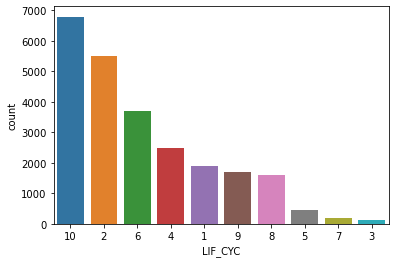

In [66]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

In [67]:
x_train_index = x_train[['HOUSEID','PERSONID']]
x_test_index = x_test[['HOUSEID','PERSONID']]
x_train.drop(['HOUSEID','PERSONID'],axis = 1, inplace = True)
x_test.drop(['HOUSEID','PERSONID'],axis = 1, inplace = True)

### 2.3.3. One-Hot- Encoding

In [68]:
x_train.dtypes

R_AGE                 int64
EDUC                  int64
R_RACE                int64
R_SEX                 int64
WRK_HOME              int64
WKFTPT                int64
OCCAT                 int64
DRIVER                int64
TRAVDAY               int64
HH_CBSA              object
HOMEOWN               int64
HHSIZE               object
HHVEHCNT             object
HHFAMINC              int64
NUMADLT             float64
YOUNGCHILD          float64
WRKCOUNT            float64
MSACAT                int64
MSASIZE               int64
URBAN                object
URBANSIZE             int64
URBRUR                int64
LIF_CYC               int64
AGE_bins             object
DISTTOWK             object
DISTTOSC             object
NUMADLT_ratio        object
YOUNGCHILD_ratio     object
WRKCOUNT_ratio       object
dtype: object

In [69]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [70]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [71]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

## 2.4. Models - First Run

To train models using only data from person and household dataset. Doing so will allow current survey method to be sufficient in predicting trips of people who did not participate in the trips measuring but participated in the household and person information survey

In [72]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Dropout

### 2.4.1. Linear Models

#### 2.4.1.1. Standard Linear Regression

In [73]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [74]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.08718551691601406
Explained Variance: 			 0.08720498556882039
Mean Absolute Error: 			 1.832432896843842
Mean Squared Error:			 5.053731900204159
Root Mean Squared Error:		 2.248050688975709
Intercept:	 -1130589539842.875
Coef:	 115


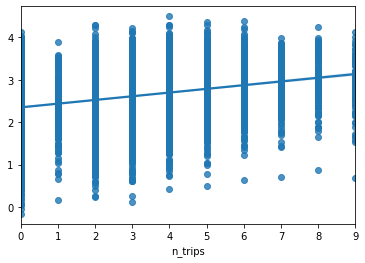

In [75]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [76]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                            feature        VIF
0                           NUMADLT  29.652321
1                        YOUNGCHILD  20.897897
2                          WRKCOUNT  61.599350
3                            EDUC_1   6.939920
4                            EDUC_2  23.252086
..                              ...        ...
110  YOUNGCHILD_ratio_more_than_0.5        inf
111                WRKCOUNT_ratio_0        inf
112                WRKCOUNT_ratio_1        inf
113    WRKCOUNT_ratio_less_than_0.5        inf
114    WRKCOUNT_ratio_more_than_0.5        inf

[115 rows x 2 columns]


In [77]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
114,WRKCOUNT_ratio_more_than_0.5,inf
81,LIF_CYC_10,inf
83,LIF_CYC_3,inf
84,LIF_CYC_4,inf
85,LIF_CYC_5,inf
...,...,...
54,HHFAMINC_3,2.856796
53,HHFAMINC_2,1.930190
50,HHFAMINC_1,1.742115
11,R_RACE_4,1.462486


In [78]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 66 infinite values


In [79]:
#cross validation to see if it will improve results 

folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_validate(LRmodel, x_train, y_train, 
                                         scoring=('r2','neg_mean_squared_error'), cv=folds)

In [80]:
scores

{'fit_time': array([0.12167335, 0.12965298, 0.12566471, 0.11369634, 0.12167406]),
 'score_time': array([0.01097155, 0.00997663, 0.01097035, 0.00997305, 0.00897646]),
 'test_r2': array([0.07537586, 0.08607386, 0.08251298, 0.0729165 , 0.07735067]),
 'test_neg_mean_squared_error': array([-5.11122182, -5.09488038, -5.12675266, -4.98344462, -5.292403  ])}

In [81]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores

{'fit_time': array([0.121673, 0.129653, 0.125665, 0.113696, 0.121674]),
 'score_time': array([0.010972, 0.009977, 0.010970, 0.009973, 0.008976]),
 'test_r2': array([0.075376, 0.086074, 0.082513, 0.072916, 0.077351]),
 'test_neg_mean_squared_error': array([-5.111222, -5.094880, -5.126753, -4.983445, -5.292403])}

In [ ]:
start_time = time.time()
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,116))}]


# perform grid search

rfe = RFE(LRmodel)             

# 3.2 call GridSearchCV()
model_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 115 candidates, totalling 575 fits
[CV 1/5; 1/115] START n_features_to_select=1....................................
[CV 1/5; 1/115] END n_features_to_select=1;, score=(train=-5.568, test=-5.528) total time=   4.5s
[CV 2/5; 1/115] START n_features_to_select=1....................................
[CV 2/5; 1/115] END n_features_to_select=1;, score=(train=-5.534, test=-5.548) total time=   4.2s
[CV 3/5; 1/115] START n_features_to_select=1....................................
[CV 3/5; 1/115] END n_features_to_select=1;, score=(train=-5.549, test=-5.579) total time=   4.2s
[CV 4/5; 1/115] START n_features_to_select=1....................................
[CV 4/5; 1/115] END n_features_to_select=1;, score=(train=-5.603, test=-5.379) total time=   4.4s
[CV 5/5; 1/115] START n_features_to_select=1....................................
[CV 5/5; 1/115] END n_features_to_select=1;, score=(train=-5.508, test=-5.747) total time=   4.1s
[CV 1/5; 2/115] START n_features_to_select

[CV 1/5; 10/115] END n_features_to_select=10;, score=(train=-5.542, test=-5.515) total time=   4.0s
[CV 2/5; 10/115] START n_features_to_select=10..................................
[CV 2/5; 10/115] END n_features_to_select=10;, score=(train=-5.478, test=-5.507) total time=   4.2s
[CV 3/5; 10/115] START n_features_to_select=10..................................
[CV 3/5; 10/115] END n_features_to_select=10;, score=(train=-5.517, test=-5.520) total time=   4.1s
[CV 4/5; 10/115] START n_features_to_select=10..................................
[CV 4/5; 10/115] END n_features_to_select=10;, score=(train=-5.574, test=-5.347) total time=   4.1s
[CV 5/5; 10/115] START n_features_to_select=10..................................
[CV 5/5; 10/115] END n_features_to_select=10;, score=(train=-5.485, test=-5.710) total time=   4.6s
[CV 1/5; 11/115] START n_features_to_select=11..................................
[CV 1/5; 11/115] END n_features_to_select=11;, score=(train=-5.536, test=-5.509) total time=   

In [ ]:
#grid_search.fit(train_features, train_labels)
print(model_cv.best_params_)

print(model_cv.best_estimator_)
print(model_cv.best_score_)

model_cv_y_pred_rfgs = model_cv.predict(x_test)
model_cv_rmse = np.sqrt(metrics.mean_squared_error(y_test, model_cv_y_pred_rfgs))
print("RMSE: %f" % (model_cv_rmse))

print("Mean squared error: %.2f"
      % metrics.mean_squared_error(y_test, model_cv_y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % metrics.r2_score(y_test, model_cv_y_pred_rfgs))

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### 2.4.1.2 Linear Regression - Regularisation

**Lasso Regularisation**

In [ ]:
start_time = time.time()
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))   

**Ridge Regularisation**

In [ ]:
start_time = time.time()
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + ridgealpha[i] * ridge_cplxy)
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

### 2.4.1.3. Principal Component Regression

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train))

In [ ]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

In [ ]:
# 5-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=10, shuffle=True, random_state=100) 

pcascores = model_selection.cross_validate(LRmodel, x_reduced, y_train, 
                                           scoring=('r2','neg_mean_squared_error'), cv=kf_5)

In [ ]:
pcascores

## 2.4.2. Ensemble Models

### 2.4.2.1. Random Forest

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [18, 21, 24],
    'oob_score': [True],
    'n_estimators': [2250, 2500, 2750]
}

# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = 3, verbose = 10)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

### 2.4.2.2.Adaboost

In [ ]:
ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[400, 500, 600],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[12, 15, 20]
}

grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=3, cv=3, verbose=10)
grid_ADA.fit(x_train, y_train)

 

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 

y_pred_ADA = grid_ADA.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### 2.4.2.3. Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [180, 200, 225],
    'max_depth'    : [5, 6, 8]
}

 

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1, verbose = 10)
grid_GBR.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_GBR = grid_GBR.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

### 2.4.2.4 XGBoost

In [ ]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.03], #so called `eta` value
              'max_depth': [11,13,15],
              'min_child_weight': [4],
              'verbosity': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [700, 800, 900]}

grid_xgb = GridSearchCV(estimator = xgb1,
                        param_grid = parameters,
                        cv = 3,
                        n_jobs = 3,
                        verbose=3)

grid_xgb.fit(x_train,
         y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_xgb = grid_xgb.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_xgb))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_xgb))

In [ ]:
best_xg = grid_xgb.best_estimator_
#best_xg.feature_importances_
plot_importance(best_xg,max_num_features =10,importance_type = 'gain')
plt.show()

### 2.4.3. Neural Network

In [ ]:
def create_model_deep(input_shape,learn_rate,dropout_rate, layers,kernel_reg): #name,my_feature_layer,dropout_rate, layers):
    model = tf.keras.models.Sequential()#name = name)
    model.add(tf.keras.Input(shape=(input_shape,)))
    #model.add(my_feature_layer)
    for index, layer in enumerate(layers):
        model.add(tf.keras.layers.Dense(units = layer,
                                        activation = 'relu',
                                        kernel_regularizer=kernel_reg,
                                        name=f'Hidden{index}'))
    model.add(Dropout(dropout_rate))  
    model.add(tf.keras.layers.Dense(units=1, name='Output'))  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learn_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
input_shape = [x_train.shape[1]]
learn_rate = ((0.001),(0.01),(0.1))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =10)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = 3, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train, y_train)
best_nn = nn_grid.best_estimator_

In [ ]:
predictions = best_nn.predict(x_test)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

In [ ]:
nn_grid_result.best_params_

| X_Train | Linear - Lasso | Ensemble - XGBoost | Nerual Network | 
|---|---|---|---|
| MSE  | 5.07 | 4.89 | 5.08 |
| RMSE | 2.24 | 2.21 | 2.25 | 
| R-Square| 0.087 | 0.117 | 0.083 | 

Overall, models did not perform well, with the best model being the XGBoost Performing at R2 of 0.117 and RMSE of 2.21. 

As such need for future exploration/feature engineering to improve models.

##  2.5. Trips

### 2.5.1. EDA

In [ ]:
ny_trips_summary = ny_trip['WHYTRP90'].value_counts().reset_index()
ny_trips_summary = ny_trips_summary.rename(columns = {'WHYTRP90':'count'})
ny_trips_summary['Trip Purpose'] = 'NA'
ny_trips_summary.loc[ny_trips_summary['index']==1,'Trip Purpose'] = "To/From Work"
ny_trips_summary.loc[ny_trips_summary['index']==2,'Trip Purpose'] = "Work-Related"
ny_trips_summary.loc[ny_trips_summary['index']==3,'Trip Purpose'] = "Shopping"
ny_trips_summary.loc[ny_trips_summary['index']==4,'Trip Purpose'] = "Family/Personal Trip"
ny_trips_summary.loc[ny_trips_summary['index']==5,'Trip Purpose'] = "School/ Church"
ny_trips_summary.loc[ny_trips_summary['index']==6,'Trip Purpose'] = "Medical/Dental"
ny_trips_summary.loc[ny_trips_summary['index']==8,'Trip Purpose'] = "Visit Relatives"
ny_trips_summary.loc[ny_trips_summary['index']==10,'Trip Purpose'] = "Social/Recreational"
ny_trips_summary.loc[ny_trips_summary['index'].isin([11,99]),'Trip Purpose'] = "Other"

ny_trips_summary = ny_trips_summary[['Trip Purpose','count']].groupby('Trip Purpose').sum().reset_index()
order = ["Shopping","Social/Recreational","Family/Personal Trip","To/From Work","Visit Relatives","School/ Church","Medical/Dental","Work-Related","Other"]

sns.barplot(data = ny_trips_summary, x= 'Trip Purpose', y = 'count',order = order)
plt.xticks(rotation=30)
plt.title('Count of Car Trips by Purpose')

As majority of car trips were for more social reasons such as Shopping, recreations, family trips, the group then explored using the trips data.

In [ ]:
trips_data = ny_trip[['HOUSEID','PERSONID','WHYTRP90','TRPMILES']]
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]
# top why trips are [3,10,4,1,8,5]

In [ ]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [ ]:
trip_summary = trips_data[['HOUSEID','PERSONID','WHYTRP90','trip_dist']].groupby(['HOUSEID','PERSONID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [ ]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','PERSONID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','PERSONID','WHYTRP90','trip_dist']]

In [ ]:
pivoted = trip_summary.pivot(index = ['HOUSEID','PERSONID'],
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})

In [ ]:
trip_why_common

In [ ]:
# Combine x_train with x_train_index 
x_train = pd.concat([x_train_index,x_train],axis = 1)

# Combine x_test with x_test_index
x_test = pd.concat([x_test_index, x_test],axis = 1)

In [ ]:
x_train_with_dist = x_train.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'], right_on = ['HOUSEID','PERSONID'])

x_test_with_dist = x_test.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'], right_on = ['HOUSEID','PERSONID'])

In [ ]:
x_test_with_dist = x_test.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'], right_on = ['HOUSEID','PERSONID'])

In [ ]:
x_test_with_dist

### 2.5.2. One Hot Encoding of Distance Metrics

In [ ]:
to_obj = ['dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']

x_train_with_dist[to_obj] = x_train_with_dist[to_obj].astype(str)
x_test_with_dist[to_obj]= x_test_with_dist[to_obj].astype(str)

In [ ]:
x_train_with_dist = pd.concat([x_train_with_dist,pd.get_dummies(x_train_with_dist[to_obj],prefix = to_obj)],axis = 1)
x_train_with_dist.drop(to_obj, axis = 1, inplace = True)

x_test_with_dist = pd.concat([x_test_with_dist,pd.get_dummies(x_test_with_dist[to_obj],prefix = to_obj)],axis = 1)
x_test_with_dist.drop(to_obj, axis = 1, inplace = True)

In [ ]:
#drop all negative value columns  

na_cols_train =[c for c in x_train_with_dist if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train_with_dist.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test_with_dist if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test_with_dist.drop(na_cols_test, axis = 1 , inplace = True)

In [ ]:
x_train_with_dist

In [ ]:
dist_dict = {'dist_to_work_(0.0, 2.0]':'dist_to_work_between_0_and_2',
            'dist_to_work_(10.0, 3621.0]':'dist_to_work_more_than_10',
            'dist_to_work_(2.0, 4.0]':'dist_to_work_between_2_and_4',
            'dist_to_work_(4.0, 10.0]':'dist_to_work_between_4_and_10',
             'dist_to_shopping_(0.0, 2.0]':'dist_to_shopping_between_0_and_2',
             'dist_to_shopping_(10.0, 3621.0]':'dist_to_shopping_more_than_10',
             'dist_to_shopping_(2.0, 4.0]':'dist_to_shopping_between_2_and_4',
             'dist_to_shopping_(4.0, 10.0]':'dist_to_shopping_between_4_and_10',
             'dist_to_family_(0.0, 2.0]':'dist_to_family_between_0_and_2',
             'dist_to_family_(10.0, 3621.0]':'dist_to_family_greater_than_10',
             'dist_to_family_(2.0, 4.0]':'dist_to_family_between_2_and_4',
             'dist_to_family_(4.0, 10.0]':'dist_to_family_between_4_and_10',
             'dist_to_school_or_church_(0.0, 2.0]':'dist_to_school_or_church_between_0_and_2',
             'dist_to_school_or_church_(10.0, 3621.0]':'dist_to_school_or_church_greater_than_10',
             'dist_to_school_or_church_(2.0, 4.0]':'dist_to_school_or_church_between_2_and_4',
             'dist_to_school_or_church_(4.0, 10.0]':'dist_to_school_or_church_between_4_and_10',
             'dist_to_relatives_(0.0, 2.0]':'dist_to_relatvies_between_0_and_2',
             'dist_to_relatives_(10.0, 3621.0]':'dist_to_relatvies_greater_than_10',
             'dist_to_relatives_(2.0, 4.0]':'dist_to_relatvies_between_2_and_4',
             'dist_to_relatives_(4.0, 10.0]':'dist_to_relatvies_between_4_and_10',
             'dist_to_social_(0.0, 2.0]':'dist_to_social_between_0_and_2',
             'dist_to_social_(10.0, 3621.0]':'dist_to_social_greater_than_10',
             'dist_to_social_(2.0, 4.0]':'dist_to_social_between_2_and_4',
             'dist_to_social_(4.0, 10.0]':'dist_to_social_between_4_and_10'}

dist_cols = [c for c in x_train_with_dist if 'dist' in c]

x_train_with_dist.rename(columns=dist_dict,inplace = True)
x_test_with_dist.rename(columns = dist_dict, inplace = True)

In [ ]:
x_train_with_dist.drop(['HOUSEID','PERSONID'],axis=1, inplace = True)
x_test_with_dist.drop(['HOUSEID','PERSONID'],axis =1 , inplace = True)

## 2.6 Models - Second Run (with Dist Features)

### 2.6.1. Linear Models

#### 2.6.1.1. Linear Regression

In [ ]:
LRmodel_with_dist = linear_model.LinearRegression()  #create the linear regression 
LRmodel_with_dist.fit(x_train_with_dist,y_train) #train the model using the training set 
LR_pred_with_dist = LRmodel_with_dist.predict(x_test_with_dist) #use this model to predict the test data set 

In [ ]:
print('R^2 score:\t\t\t\t',LRmodel_with_dist.score(x_test_with_dist, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred_with_dist)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred_with_dist)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel_with_dist.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel_with_dist.coef_!=0))#find no of features used in regression model 

In [ ]:
sns.regplot(y_test,LR_pred_with_dist) #plotting predictions 

In [ ]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data_with_dist = pd.DataFrame()
vif_data_with_dist["feature"] = x_train_with_dist.columns
  
# calculating VIF for each feature
vif_data_with_dist["VIF"] = [variance_inflation_factor(x_train_with_dist.values, i)
                          for i in range(len(x_train_with_dist.columns))]
  
print(vif_data_with_dist)

In [ ]:
vif_data_with_dist.sort_values(by = 'VIF', ascending = False)

In [ ]:
# counting number of infinity features 

vif_data_inf_with_dist = np.isinf(vif_data_with_dist['VIF']).values.sum()
print("It contains " + str(vif_data_inf_with_dist) + " infinite values")

In [ ]:
#cross validation to see if it will improve results 
folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores_with_dist = model_selection.cross_validate(LRmodel_with_dist, x_train_with_dist, y_train, 
                                                  scoring=('r2','neg_mean_squared_error'), cv=folds)

In [ ]:
scores_with_dist

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores_with_dist

In [ ]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,140))}]


# perform grid search

rfe_with_dist = RFE(LRmodel_with_dist)             

# 3.2 call GridSearchCV()
model_cv_with_dist = model_selection.GridSearchCV(estimator = rfe_with_dist, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv_with_dist.fit(x_train_with_dist, y_train)

In [ ]:
#grid_search.fit(train_features, train_labels)
print(model_cv_with_dist.best_params_)

print(model_cv_with_dist.best_estimator_)
print(model_cv_with_dist.best_score_)

model_cv_with_dist_y_pred_rfgs = model_cv_with_dist.predict(x_test_with_dist)
model_cv_with_dist_rmse = np.sqrt(metrics.mean_squared_error(y_test, model_cv_with_dist_y_pred_rfgs))
print("RMSE: %f" % (model_cv_with_dist_rmse))

print("Mean squared error: %.2f"
      % metrics.mean_squared_error(y_test, model_cv_with_dist_y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % metrics.r2_score(y_test, model_cv_with_dist_y_pred_rfgs))

In [ ]:
# cv results
cv_results_with_dist = pd.DataFrame(model_cv_with_dist.cv_results_)
cv_results_with_dist

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
#plt.plot(cv_results_with_dist["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

### 2.6.1.2 Linear Regression – Regularisation

**Lasso Regularisation**

In [ ]:
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso_with_dist = linear_model.Lasso(alpha=alpha[i])
    lasso_with_dist.fit(x_train_with_dist, y_train) #fit a lasso regression on the training data
    y_predlasso_with_dist = lasso_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    lasso_mse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist) #calculate the test MSE
    lasso_rmse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist,squared = False) #calculate the test RMSE
    msemanual_with_dist = np.mean((y_predlasso_with_dist-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy_with_dist = (np.sum(abs(lasso_with_dist.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso_with_dist.score(x_train_with_dist, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso_with_dist.score(x_test_with_dist, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso_with_dist.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse_with_dist) #compute MSE results
    print('Manual MSE on test set:',msemanual_with_dist) #compute MSE results
    print('RMSE on test set:', lasso_rmse_with_dist) #compute RMSE results
    print('model complexity:', lasso_cplxy_with_dist) #compute L1 NOMR score
    print('regularized cost:', lasso_mse_with_dist + alpha[i] * lasso_cplxy_with_dist) #compute regularised cost function scores
    print('\n')


**Ridge Regularisation**

In [ ]:
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge_with_dist = linear_model.Ridge(alpha=ridgealpha[i])
    ridge_with_dist.fit(x_train_with_dist, y_train) #fit a ridge regression on the training data
    y_pred_ridge_with_dist = ridge_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    ridge_mse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist) #calculate the test mse
    ridge_rmse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist,squared = False) #calculate the test rmse
    ridge_cplxy_with_dist = (np.linalg.norm(ridge_with_dist.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge_with_dist.score(x_train_with_dist, y_train), 3))
    print('Test score:', round(ridge_with_dist.score(x_test_with_dist, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge_with_dist.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse_with_dist)
    print('RMSE on test set:', ridge_rmse_with_dist)
    print('model complexity:', ridge_cplxy_with_dist)
    print('regularized cost:', ridge_mse_with_dist + ridgealpha[i] * ridge_cplxy_with_dist)
    print('\n')

### 2.6.1.3. Principal Component Regression

In [ ]:
pca_with_dist = PCA()
x_reduced_with_dist = pca_with_dist.fit_transform(scale(x_train_with_dist))

In [ ]:
pd.DataFrame(pca_with_dist.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

In [ ]:
# 10-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)

pcascores_with_dist = model_selection.cross_validate(LRmodel_with_dist, x_reduced_with_dist, y_train, 
                                                               scoring=('r2','neg_mean_squared_error'), cv=kf_5)

In [ ]:
pcascores_with_dist

## 2.6.2. Ensemble Models

###  2.6.2.1. Random Forest 

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [30, 33, 36],
    'oob_score': [True],
    'n_estimators': [2500, 2750, 3000]
}

# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = 3, verbose = 10)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train_with_dist, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

### 2.6.2.2. Adaboost

In [ ]:
ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[800, 900, 1000],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[25, 30, 35]
}


grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=3, cv=3, verbose=10)
grid_ADA.fit(x_train_with_dist, y_train)

 
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 
y_pred_ADA = grid_ADA.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### 2.6.2.3. Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [250, 275, 300],
    'max_depth'    : [2, 3, 4, 5]
}

 
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=3, verbose = 10)
grid_GBR.fit(x_train_with_dist, y_train)


print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))
 

y_pred_GBR = grid_GBR.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

### 2.6.2.4. XGBoost 

In [ ]:
start_time = time.time()

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.03], #so called `eta` value
              'max_depth': [7, 9,11],
              'min_child_weight': [4],
              'verbosity': [2],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [1000, 1200, 1400]}

grid_xgb = GridSearchCV(estimator = xgb1,
                        param_grid = parameters,
                        cv = 3,
                        n_jobs = 3,
                        verbose=10)

grid_xgb.fit(x_train_with_dist,
         y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_xgb = grid_xgb.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_xgb))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_xgb))

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
best_xg = grid_xgb.best_estimator_
#best_xg.feature_importances_
plot_importance(best_xg,max_num_features =10,importance_type = 'gain')


#plot_importance(xgb1,max_num_features =20,importance_type = 'gain')
plt.show()

### 2.6.2.5. Neural Network

In [ ]:
#use the same param_grid as earlier

start_time = time.time()

input_shape = [x_train_with_dist.shape[1]]
learn_rate = ((0.001),(0.01),(0.1))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =10)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = 3, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train_with_dist, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
predictions = best_nn.predict(x_test_with_dist)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

In [ ]:
nn_grid_result.best_params_

| X_Train_with_dist | Linear - Lasso | Ensemble - XGBoost | Nerual Network | 
|---|---|---|---|
| MSE  | 2.81 | 2.68| 2.79 |
| RMSE | 1.68 | 1.63 | 1.67 | 
| R-Square| 0.492 | 0.517 | 0.496 | 


Overall, adding distance features improved all models significantly and hence reccommendation is for future surveys to add in questions regarding main why column to ask distance bins.

e.g. select from bins the distance to workplace for each member of the family 
